# IFT6390 Project - Data Exploration snippets

## Useful piece of code

## Setup - data

In [203]:
print(__doc__)

!pip install keras
!{sys.executable} -m pip install scikit-plot

import keras
import scikitplot as skplt

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import sys


#Natural Language Toolkit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#identifies words which are not adding semantic value to the sentence
stopw = set(stopwords.words('english'))

Automatically created module for IPython interactive environment


[nltk_data] Downloading package stopwords to /home/rd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import cleaned dataframe

In [204]:
a=datetime.datetime.now()

s140=pd.read_pickle('data/s140_clean_28nov.pkl')
mr=pd.read_pickle('data/mr_clean_28nov.pkl')
cc=pd.read_pickle('data/cc_clean_28nov.pkl')

print(datetime.datetime.now()-a)

0:00:06.817698


In [205]:
s140.target

0          negative
1          negative
2          negative
3          negative
4          negative
             ...   
1600493    positive
1600494    positive
1600495    positive
1600496    positive
1600497    positive
Name: target, Length: 1600498, dtype: object

In [206]:
print('NaN before replace: ', cc.target.isna().sum())
cc=cc.replace({'target': {np.nan: 'Not Sure'}})
print('NaN after replace: ', cc.target.isna().sum())

def nnlabel(df):
    return df.replace({'target': {'positive':1,'Not Sure':0,'neutral':0,'negative':2}})

cc=nnlabel(cc)
mr=nnlabel(mr)
s140=nnlabel(s140)

NaN before replace:  1840
NaN after replace:  0


In [207]:
from sklearn.feature_extraction.text import TfidfVectorizer 

def make_tfidf(df):
    tf_vect=TfidfVectorizer(use_idf=False,stop_words=stopw)
    tf=tf_vect.fit_transform(df.tolist())
    
    l=tf.shape[0]
    
    w_count=np.array(tf.sum(axis=0,))[0]/l
    #wcm=w_count.max()
    #w_count=w_count/wcm
    wcr=w_count.argsort()[::-1].argsort()

    
    idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
    idf=idf_vect.fit_transform(df.tolist())
    
    w_marker=np.array(idf.sum(axis=0))[0]/l
    #wmm=w_marker.max()
    #w_marker=w_marker/wmm
    wmr=w_marker.argsort()[::-1].argsort()
    
    
    # SRC -> https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
    feature_names=tf_vect.get_feature_names()
    
    tf_idf = pd.DataFrame(np.array([w_count, w_marker, wcr, wmr]).T, index=feature_names, columns=["tf", "idf", "rank_tf", "rank_idf"])
    tf_idf = tf_idf.sort_values(by=["tf"],ascending=False)

    tf_idf.rank_tf=tf_idf.rank_tf.astype('int64')
    tf_idf.rank_idf=tf_idf.rank_idf.astype('int64')

    return tf_idf


## Transform s140

In [208]:
#all=make_tfidf(s140['trimmed'])

In [209]:
a=datetime.datetime.now()

tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
s140_tf_idf=tf_idf_vect.fit_transform(s140['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:28.192165


## Transform MR

In [210]:
a=datetime.datetime.now()

tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
mr_tf_idf=tf_idf_vect.fit_transform(mr['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:07.257397


## Transform CC

In [211]:
a=datetime.datetime.now()

tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
cc_tf_idf=tf_idf_vect.fit_transform(cc['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:00.182701


## Model testing

In [299]:
#import scikitplot as skplt
#import scikitplot#.plotters as skplt

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#The mean score and the 95% confidence interval of the score estimate are hence given by:

def crossval(model, x, y):    
    scores = cross_val_score(model, x, y, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

def confusion(y_valid,predicted):
    if len(y_valid.shape)!=1 or len(predicted.shape)!=1:
        y_v=np.argmax(y_valid,axis=1)
        pred=np.argmax(predicted,axis=1)
    skplt.metrics.plot_confusion_matrix(y_v, pred,x_tick_rotation=90,figsize=(3,6), normalize=True)
    plt.show()  
    
def TryModel(model, xt, yt,xv=0,yv=0, selfie=True):  
    if selfie:
        X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    else:
        X_train, X_valid, y_train, y_valid=xt,xv,yt,yv

    clf = model.fit(X_train, y_train)

    predicted = clf.predict(X_valid)

    acc=accuracy_score(y_valid, predicted)
    print(f"Accuracy: {acc}")

    confusion(y_valid,predicted)

    return y_valid,predicted


from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

## Data
#data = np.random.random((1000,100))
#labels = np.random.randint(2,size=(1000,1))

class nn:
    def __init__(self, model=None, pred=None,y=None):
        self.model = model
        self.pred = pred
        self.y = y
        
    def train(self, x,y,epoch=1,layers=16):
        # Define network (model)
        self.model = Sequential() 

        self.y = to_categorical(y,3)
        self.model.add(Dense(layers, activation='relu', input_dim=x.shape[1]))
        self.model.add(Dense(self.y.shape[1], activation='sigmoid'))

        # Configure training
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model by training
        self.model.fit(x,self.y,epochs=epoch,batch_size=32)
        
    def predict(self, x_test, y_test=None):
        # Make predictions
        if not not list(y_test):
            self.y=to_categorical(y_test,3)
        self.pred=self.model.predict(x_test)
        return self.y,self.model.predict(x_test)
    
    def evalnn(self,x,y):
        test_loss, test_acc = self.model.evaluate(x,y)
        return test_loss, test_acc
    
    def plot(self):
        plt.plot(self.model.history['loss'])
        plt.plot(self.model.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper right')
        plt.show()

## Trained and tested on the same dataset (selfie)

### mr

Epoch 1/2
50000/50000 [==============================] - 83s 2ms/step - loss: 0.4461 - accuracy: 0.8567
Epoch 2/2
50000/50000 [==============================] - 83s 2ms/step - loss: 0.2124 - accuracy: 0.9158


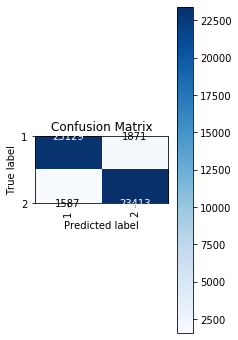

In [220]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

mrNN=nn()
mrNN.train(x, y,2)
mr_y,mr_pred=mrNN.predict(x)
confusion(mr_y,mr_pred)

#print(datetime.datetime.now()-a)

### cc

Epoch 1/10
6027/6027 [==============================] - 3s 545us/step - loss: 1.0300 - accuracy: 0.5090
Epoch 2/10
6027/6027 [==============================] - 3s 461us/step - loss: 0.9291 - accuracy: 0.5228
Epoch 3/10
6027/6027 [==============================] - 2s 387us/step - loss: 0.8420 - accuracy: 0.5852
Epoch 4/10
6027/6027 [==============================] - 2s 399us/step - loss: 0.7503 - accuracy: 0.6784
Epoch 5/10
6027/6027 [==============================] - 3s 459us/step - loss: 0.6676 - accuracy: 0.7420
Epoch 6/10
6027/6027 [==============================] - 2s 387us/step - loss: 0.6046 - accuracy: 0.7710
Epoch 7/10
6027/6027 [==============================] - 3s 418us/step - loss: 0.5591 - accuracy: 0.7870
Epoch 8/10
6027/6027 [==============================] - 2s 402us/step - loss: 0.5255 - accuracy: 0.7976
Epoch 9/10
6027/6027 [==============================] - 3s 417us/step - loss: 0.4979 - accuracy: 0.8075
Epoch 10/10
6027/6027 [==============================] - 2s 407u

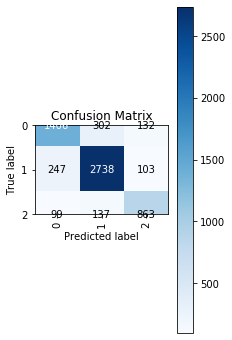

0:00:28.336454


In [218]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = cc_tf_idf, cc['target']

ccNN=nn()
ccNN.train(x, y, 10)
cc_y, cc_pred=ccNN.predict(x)
confusion(cc_y,cc_pred)

import pickle

pickling_on = open("ccNN.pkl","wb")
pickle.dump(ccNN, pickling_on)
pickling_on.close()

pickling_on = open("trained_on_CC_tested_on_CC.pkl","wb")
pickle.dump((cc_y,cc_pred), pickling_on)
pickling_on.close()

print(datetime.datetime.now()-a)

### s140

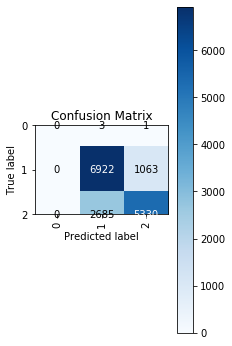

0:00:00.266848


In [298]:
a=datetime.datetime.now()

x,y = s140_tf_idf, s140['target']


k=int(0.01*y.shape[0])
np.random.seed(99)
sample=np.random.randint(0,y.shape[0],k)

x_test=x[sample]
y_test=y[sample]

np.random.seed(199)
sample=np.random.randint(0,y.shape[0],k)

x=x[sample]
y=y[sample]

#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

s140NN=nn()
s140NN.train(x, y)
s140_y,s140_pred=s140NN.predict(x_test,y_test)
confusion(s140_y,s140_pred)

print(datetime.datetime.now()-a)

## Pickling

In [ ]:
import pickle

pickling_on = open("s140NN.pkl","wb")
pickle.dump(s140NN, pickling_on)
pickling_on.close()

pickling_on = open("trained_on_s140_tested_on_s140.pkl","wb")
pickle.dump((s140_y,s140_pred), pickling_on)
pickling_on.close()

In [195]:
import pickle

pickling_on = open("ccNN.pkl","wb")
pickle.dump(ccNN, pickling_on)
pickling_on.close()

pickling_on = open("trained_on_CC_tested_on_CC.pkl","wb")
pickle.dump((cc_y,cc_pred), pickling_on)
pickling_on.close()

In [221]:
pickling_on = open("mrNN.pkl","wb")
pickle.dump(mrNN, pickling_on)
pickling_on.close()

pickling_on = open("trained_on_MR_tested_on_MR.pkl","wb")
pickle.dump((mr_y,mr_pred), pickling_on)
pickling_on.close()

In [ ]:
pickle_off = open("mrNN.pkl","rb")
mrNN2 = pickle.load(pickle_off)

# Cross-Trained

## NN Movies trained w S140

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=s140NN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN CC trained w S140

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = cc_tf_idf, cc['target']

pred=s140NN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN Movies trained w CC

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=ccNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN CC trained w Movies

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = cc_tf_idf, cc['target']

pred=mrNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN s140 trained w CC

In [ ]:
a=datetime.datetime.now()

x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=ccNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN s140 trained w Movies

In [ ]:
a=datetime.datetime.now()

x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=mrNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)